<a href="https://colab.research.google.com/github/makowskiignacy/PELN/blob/main/Drzewa_martwe_drewna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from matplotlib import colormaps


In [170]:
# === KROK 1: Przygotowanie danych ===
# W realnym scenariuszu wczytałbyś dane z pliku CSV, np.:
dane1 = pd.read_csv('data/PELN - Van Wagner NS (martwe drewno).csv')
dane2 = pd.read_csv('data/PELN - Van Wagner WZ (martwe drewno).csv')

# Standaryzacja nazw kolumn i konwersja na angielski dla spójności
dane1.columns = ['Nr linii', 'Nr kwadratu', 'Gatunek', 'Srednica w przecieciu']
dane2.columns = ['Nr linii', 'Gatunek', 'Srednica w przecieciu', 'Nr kwadratu']
dane1['Pomiar'] = np.zeros(len(dane1))
dane2['Pomiar'] = np.ones(len(dane2))

# Uporządkowanie kolumn w dane2, aby pasowały do dane1
dane2 = dane2[['Nr linii', 'Nr kwadratu', 'Gatunek', 'Srednica w przecieciu', 'Pomiar']]

# Konwersja kolumny 'Srednica w przecieciu' na typ numeryczny,
# uwzględniając możliwe przecinki jako separatory dziesiętne i błędy
dane1['Srednica w przecieciu'] = dane1['Srednica w przecieciu'].astype(str).str.replace(',', '.', regex=False)
dane2['Srednica w przecieciu'] = dane2['Srednica w przecieciu'].astype(str).str.replace(',', '.', regex=False)
dane1['Srednica w przecieciu'] = pd.to_numeric(dane1['Srednica w przecieciu'], errors='coerce')
dane2['Srednica w przecieciu'] = pd.to_numeric(dane2['Srednica w przecieciu'], errors='coerce')


# Połączenie danych przy użyciu concat (dodanie wierszy jednego do drugiego)
dane = pd.concat([dane1, dane2], ignore_index=True)

# Zmiana nazw kolumn na mniejsze litery i angielskie nazwy
dane.columns = ['nr_linii', 'nr_kwadratu', 'gatunek', 'srednica_cm', 'pomiar']

# Usunięcie wierszy z brakującymi wartościami, które mogły powstać po konwersji numerycznej
dane.dropna(inplace=True)

# Upewnienie się, że kolumny liczbowe są odpowiedniego typu
dane['nr_linii'] = dane['nr_linii'].astype(int)
dane['nr_kwadratu'] = dane['nr_kwadratu'].astype(int)
dane['srednica_cm'] = dane['srednica_cm'].astype(float)

print(dane['nr_linii'].max())
print(dane1['Nr linii'].max())
print(dane2['Nr linii'].max())

6
5
6


In [171]:
dane_test = pd.read_csv('data/PELN - Van Wagner całkowity pomiar (martwe drewno).csv')
dane_test.columns = ['nr_linii', 'nr_kwadratu', 'gatunek', 'srednica_cm', 'dlugosc']
dane_test['dlugosc'] = dane_test['dlugosc'].astype(str).str.replace(',', '.', regex=False)
dane_test['srednica_cm'] = dane_test['srednica_cm'].astype(str).str.replace(',', '.', regex=False)
dane_test['dlugosc'] = pd.to_numeric(dane_test['dlugosc'], errors='coerce')
dane_test['srednica_cm'] = pd.to_numeric(dane_test['srednica_cm'], errors='coerce')
dane_test['objetosc'] = dane_test['dlugosc'] * np.pi * (dane_test['srednica_cm']/200)**2
dane_test.head()

,nr_linii,nr_kwadratu,gatunek,srednica_cm,dlugosc,objetosc
0,1,1,sw,22.5,19.70,0.783287
1,1,1,db,13.0,6.70,0.088931
2,1,2,sw,15.0,1.18,0.020852
3,1,2,sw,11.5,2.00,0.020774
4,1,3,os,7.0,2.00,0.007697


In [172]:
ns_data = dane[dane['pomiar'] == 0]
wz_data = dane[dane['pomiar'] == 1]

# Process NS and WZ data for each square
def podziel_na_kwadraty(data_ns, data_wz, rozmiar_kwadratu=3):
    wyniki = []
    max_x = max(data_ns['nr_linii'].max(), data_wz['nr_linii'].max())
    max_y = max(data_ns['nr_kwadratu'].max(), data_wz['nr_kwadratu'].max())

    kwadrat_id = 1
    print(max_x - rozmiar_kwadratu + 1)
    print(max_y - rozmiar_kwadratu + 1)
    for start_x in range(1, max_x - rozmiar_kwadratu + 1):
        for start_y in range(1, max_y - rozmiar_kwadratu + 1):
            kwadrat_dict = {
                "kwadrat_id": kwadrat_id,
                "start_wspolrzedne": (start_x, start_y),
                "NS1": [], "NS2": [], "NS3": [], "NS4": [],
                "WZ1": [], "WZ2": [], "WZ3": [], "WZ4": []
            }

            # Collect NS data
            for i in range(rozmiar_kwadratu):
                wspolrzedne_ns = [(start_x + i, start_y), (start_x + i, start_y + 1), (start_x + i, start_y + 2)]
                ns_key = f"NS{i+1}"
                for wsp in wspolrzedne_ns:
                    obserwacje = data_ns[(data_ns['nr_linii'] == wsp[0]) & (data_ns['nr_kwadratu'] == wsp[1])]
                    if not obserwacje.empty:
                        kwadrat_dict[ns_key].extend(obserwacje[['gatunek', 'srednica_cm']].values.tolist())

            # Collect WZ data
            for i in range(rozmiar_kwadratu):
                wspolrzedne_wz = [(start_x, start_y + i), (start_x + 1, start_y + i), (start_x + 2, start_y + i)]
                wz_key = f"WZ{i+1}"
                for wsp in wspolrzedne_wz:
                    obserwacje = data_wz[(data_wz['nr_linii'] == wsp[0]) & (data_wz['nr_kwadratu'] == wsp[1])]
                    if not obserwacje.empty:
                        kwadrat_dict[wz_key].extend(obserwacje[['gatunek', 'srednica_cm']].values.tolist())

            wyniki.append(kwadrat_dict)
            kwadrat_id += 1

    return wyniki

# Generate results
wyniki_kwadratow = podziel_na_kwadraty(ns_data, wz_data)

# Display results
for wynik in wyniki_kwadratow:
    print(f"Kwadrat: {wynik['start_wspolrzedne']}")
    print(f"NS1: {wynik['NS1']}, NS2: {wynik['NS2']}, NS3: {wynik['NS3']}, NS4: {wynik['NS4']}")
    print(f"WZ1: {wynik['WZ1']}, WZ2: {wynik['WZ2']}, WZ3: {wynik['WZ3']}, WZ4: {wynik['WZ4']}")
    print()

4
9
Kwadrat: (1, 1)
NS1: [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0]], NS2: [], NS3: [['sw', 23.0], ['sw', 37.0]], NS4: []
WZ1: [['sw ', 11.0], ['br', 21.0], ['br', 29.0], ['os', 18.0], ['sw ', 20.0]], WZ2: [['sw ', 33.0]], WZ3: [['sw ', 13.5], ['db', 17.0]], WZ4: []

Kwadrat: (1, 2)
NS1: [['db', 18.0], ['sw', 13.0]], NS2: [['sw', 22.0]], NS3: [['sw', 37.0], ['db', 16.0]], NS4: []
WZ1: [['sw ', 33.0]], WZ2: [['sw ', 13.5], ['db', 17.0]], WZ3: [['sw ', 20.0], ['db', 14.0]], WZ4: []

Kwadrat: (1, 3)
NS1: [], NS2: [['sw', 22.0], ['db', 17.0]], NS3: [['db', 16.0]], NS4: []
WZ1: [['sw ', 13.5], ['db', 17.0]], WZ2: [['sw ', 20.0], ['db', 14.0]], WZ3: [['br', 11.5]], WZ4: []

Kwadrat: (1, 4)
NS1: [], NS2: [['sw', 22.0], ['db', 17.0]], NS3: [['db', 16.0]], NS4: []
WZ1: [['sw ', 20.0], ['db', 14.0]], WZ2: [['br', 11.5]], WZ3: [], WZ4: []

Kwadrat: (1, 5)
NS1: [], NS2: [['db', 17.0], ['db', 10.0]], NS3: [], NS4: []
WZ1: [['br', 11.5]], WZ2: [], WZ3: [['sw ', 15.0]], WZ4: []

Kwadrat:

In [173]:
# Funkcja do podziału siatki na kwadraty 3x3
def podziel_na_kwadraty(data, rozmiar_kwadratu=3):
    wyniki = {"Kwadrat": [], "objetosc": []}
    max_x = data['nr_linii'].max()
    print(max_x)
    max_y = data['nr_kwadratu'].max()
    print(max_y)

    for start_x in range(1, max_x - rozmiar_kwadratu + 2):
        for start_y in range(1, max_y - rozmiar_kwadratu + 2):
            # Filtruj dane dla aktualnego kwadratu
            kwadrat = data[
                (data['nr_linii'] >= start_x) & (data['nr_linii'] < start_x + rozmiar_kwadratu) &
                (data['nr_kwadratu'] >= start_y) & (data['nr_kwadratu'] < start_y + rozmiar_kwadratu)
            ]
            # Dodaj gatunki i średnice do wyników
            wyniki["Kwadrat"].append(f"({start_x}, {start_y})")
            # Calculate and append the sum of 'objetosc' for the current square
            wyniki["objetosc"].append(kwadrat['objetosc'].sum())

    # Create a list of dictionaries for easier printing
    wyniki_list = []
    for i in range(len(wyniki["Kwadrat"])):
        wyniki_list.append({
            "Kwadrat": wyniki["Kwadrat"][i],
            "objetosc": wyniki["objetosc"][i]
        })

    return wyniki_list


# Wywołanie funkcji
wyniki = podziel_na_kwadraty(dane_test)

# Wyświetlenie wyników
for wynik in wyniki:
    print(f"Kwadrat: {wynik['Kwadrat']}, Objętość: {wynik['objetosc']}")

5
10
Kwadrat: (1, 1), Objętość: 7.270652673551339
Kwadrat: (1, 2), Objętość: 5.375133476099767
Kwadrat: (1, 3), Objętość: 3.7006590939492634
Kwadrat: (1, 4), Objętość: 0.734121873503719
Kwadrat: (1, 5), Objętość: 6.701932511666469
Kwadrat: (1, 6), Objętość: 8.810198007424653
Kwadrat: (1, 7), Objętość: 15.351767529389548
Kwadrat: (1, 8), Objętość: 10.328074205969827
Kwadrat: (2, 1), Objętość: 6.237506549996391
Kwadrat: (2, 2), Objętość: 5.146502107239361
Kwadrat: (2, 3), Objętość: 3.574527683199369
Kwadrat: (2, 4), Objętość: 0.6683875815190881
Kwadrat: (2, 5), Objętość: 8.326451643634076
Kwadrat: (2, 6), Objętość: 10.767924666408117
Kwadrat: (2, 7), Objętość: 14.289732497889432
Kwadrat: (2, 8), Objętość: 7.643489035697741
Kwadrat: (3, 1), Objętość: 4.477346799015552
Kwadrat: (3, 2), Objętość: 2.874525862108125
Kwadrat: (3, 3), Objętość: 5.727877389731055
Kwadrat: (3, 4), Objętość: 3.116487401296794
Kwadrat: (3, 5), Objętość: 10.676494502711613
Kwadrat: (3, 6), Objętość: 8.90961567044290

In [174]:
def generuj_wiersze(wyniki_kwadratow):
    wiersze = []

    for kwadrat in wyniki_kwadratow:
        start_wspolrzedne = kwadrat['start_wspolrzedne']

        # Extract NS and WZ keys
        NS_keys = ['NS1', 'NS2', 'NS3', 'NS4']
        WZ_keys = ['WZ1', 'WZ2', 'WZ3', 'WZ4']

        # Generate rows for each NS-WZ combination
        for ns_key in NS_keys:
            ns_value = kwadrat.get(ns_key, [])
            for wz_key in WZ_keys:
                wz_value = kwadrat.get(wz_key, [])

                # Combine NS and WZ values into a single row
                wiersze.append({
                    'Kwadrat': start_wspolrzedne,
                    'NS_WZ': f"{ns_key}{wz_key}",
                    'obserwacje': [*ns_value, *wz_value]
                })

    return wiersze


kombinacje = generuj_wiersze(wyniki_kwadratow)

# Display results
for k in kombinacje:
    print(k)

{'Kwadrat': (1, 1), 'NS_WZ': 'NS1WZ1', 'obserwacje': [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0], ['sw ', 11.0], ['br', 21.0], ['br', 29.0], ['os', 18.0], ['sw ', 20.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS1WZ2', 'obserwacje': [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0], ['sw ', 33.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS1WZ3', 'obserwacje': [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0], ['sw ', 13.5], ['db', 17.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS1WZ4', 'obserwacje': [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS2WZ1', 'obserwacje': [['sw ', 11.0], ['br', 21.0], ['br', 29.0], ['os', 18.0], ['sw ', 20.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS2WZ2', 'obserwacje': [['sw ', 33.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS2WZ3', 'obserwacje': [['sw ', 13.5], ['db', 17.0]]}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS2WZ4', 'obserwacje': []}
{'Kwadrat': (1, 1), 'NS_WZ': 'NS3WZ1', 'obserwacje': [['sw', 23.0], ['sw', 37.0], ['sw ', 11.0], ['br'

In [175]:
obj = pd.DataFrame(wyniki)
type(obj.iloc[0][0])

/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_89966/2144753668.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(obj.iloc[0][0])


str

In [176]:
df = pd.DataFrame(kombinacje)
type(df.iloc[0][0])

/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_89966/3995174379.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(df.iloc[0][0])


tuple

In [177]:
# Convert coordinates to string format for proper merging
df['Kwadrat'] = df['Kwadrat'].astype(str)
obj['Kwadrat'] = obj['Kwadrat'].astype(str)

print("df columns:", df.columns.tolist())
print("obj columns:", obj.columns.tolist())
print("First few rows of df:")
print(df.head())
print("First few rows of obj:")
print(obj.head())

# Łączenie tabel na podstawie kolumny 'Kwadrat'
polaczona_tabela = pd.merge(df, obj, on='Kwadrat', how='left').drop(columns=['Kwadrat', 'NS_WZ'])
polaczona_tabela.columns = ['obserwacje', 'objetosc']

# Wyświetlenie wyników
print("Final merged table:")
print(polaczona_tabela.head())
print("Shape:", polaczona_tabela.shape)
print("Columns:", polaczona_tabela.columns.tolist())

df columns: ['Kwadrat', 'NS_WZ', 'obserwacje']
obj columns: ['Kwadrat', 'objetosc']
First few rows of df:
  Kwadrat   NS_WZ                                         obserwacje
0  (1, 1)  NS1WZ1  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...
1  (1, 1)  NS1WZ2  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...
2  (1, 1)  NS1WZ3  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...
3  (1, 1)  NS1WZ4   [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]
4  (1, 1)  NS2WZ1  [[sw , 11.0], [br, 21.0], [br, 29.0], [os, 18....
First few rows of obj:
  Kwadrat  objetosc
0  (1, 1)  7.270653
1  (1, 2)  5.375133
2  (1, 3)  3.700659
3  (1, 4)  0.734122
4  (1, 5)  6.701933
Final merged table:
                                          obserwacje  objetosc
0  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
1  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
2  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
3   [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]  7.270653
4 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Debug: Check what we have in our dataframes
print("Columns in df (kombinacje):", df.columns.tolist() if 'df' in locals() else "df not defined")
print("Columns in obj (wyniki):", obj.columns.tolist() if 'obj' in locals() else "obj not defined")
print("Columns in polaczona_tabela:", polaczona_tabela.columns.tolist())
print("Shape of polaczona_tabela:", polaczona_tabela.shape)
print("First few rows of polaczona_tabela:")
print(polaczona_tabela.head())

# Check if we need to recreate the merged table
if 'objetosc' not in polaczona_tabela.columns:
    print("Recreating the merged table...")
    # Recreate the merge operation properly
    df = pd.DataFrame(kombinacje)
    obj = pd.DataFrame(wyniki)
    
    # Convert coordinates to string format for merging
    df['Kwadrat'] = df['Kwadrat'].astype(str)
    
    # Merge tables
    polaczona_tabela = pd.merge(df, obj, on='Kwadrat', how='left').drop(columns=['Kwadrat', 'NS_WZ'])
    polaczona_tabela.columns = ['obserwacje', 'objetosc']
    
    print("Recreated table columns:", polaczona_tabela.columns.tolist())
    print("Recreated table shape:", polaczona_tabela.shape)

# Use the corrected data
data = polaczona_tabela.copy()

# Clean data - remove rows with NaN in target variable and empty observations
data = data.dropna(subset=['objetosc'])
data = data[data['obserwacje'].apply(lambda x: len(x) > 0)]  # Remove rows with empty observations
data = data.reset_index(drop=True)

print(f"Data shape after cleaning: {data.shape}")
if len(data) > 0:
    print(f"Target variable stats: min={data['objetosc'].min():.4f}, max={data['objetosc'].max():.4f}, mean={data['objetosc'].mean():.4f}")
else:
    print("No data remaining after cleaning!")

# Preprocessing data
def preprocess_data(data, encoder=None):
    # Separate strings and floats from observation lists
    texts = [' '.join([str(item[0]) for item in obs]) for obs in data['obserwacje']]
    floats = [np.mean([item[1] for item in obs]) if obs else 0 for obs in data['obserwacje']]

    # OneHotEncoding for strings
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        text_features = encoder.fit_transform(np.array(texts).reshape(-1, 1))
    else:
        text_features = encoder.transform(np.array(texts).reshape(-1, 1))

    # Combine text features and numerical features
    features = np.hstack([text_features, np.array(floats).reshape(-1, 1)])
    return features, encoder

# Process data
X, encoder = preprocess_data(data)
y = data['objetosc']

# Check for any remaining NaN values
print(f"NaN values in X: {np.isnan(X).sum()}")
print(f"NaN values in y: {np.isnan(y).sum()}")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation
def augment_data(X, percentage=0.1):
    X_augmented = X.copy()
    num_rows_to_augment = int(X.shape[0] * percentage)
    if num_rows_to_augment > 0:
        rows_to_augment = np.random.choice(X.shape[0], num_rows_to_augment, replace=False)
        
        # The one-hot encoded features are all but the last column
        num_one_hot_features = X.shape[1] - 1
        
        for row_idx in rows_to_augment:
            X_augmented[row_idx, :num_one_hot_features] = 0
            
    return X_augmented

X_train_aug = augment_data(X_train, percentage=0.1)

# Define model and hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for hyperparameter tuning
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_aug, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")


Columns in df (kombinacje): ['Kwadrat', 'NS_WZ', 'obserwacje']
Columns in obj (wyniki): ['Kwadrat', 'objetosc']
Columns in polaczona_tabela: ['obserwacje', 'objetosc']
Shape of polaczona_tabela: (384, 2)
First few rows of polaczona_tabela:
                                          obserwacje  objetosc
0  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
1  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
2  [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653
3   [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]  7.270653
4  [[sw , 11.0], [br, 21.0], [br, 29.0], [os, 18....  7.270653
Data shape after cleaning: (339, 2)
Target variable stats: min=0.6684, max=15.3518, mean=7.1128
NaN values in X: 0
NaN values in y: 0
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n

Mean Absolute Error (MAE): 2.655901519036186
Mean Squared Error (MSE): 11.966292144156933
R² Score: 0.1574974901968902


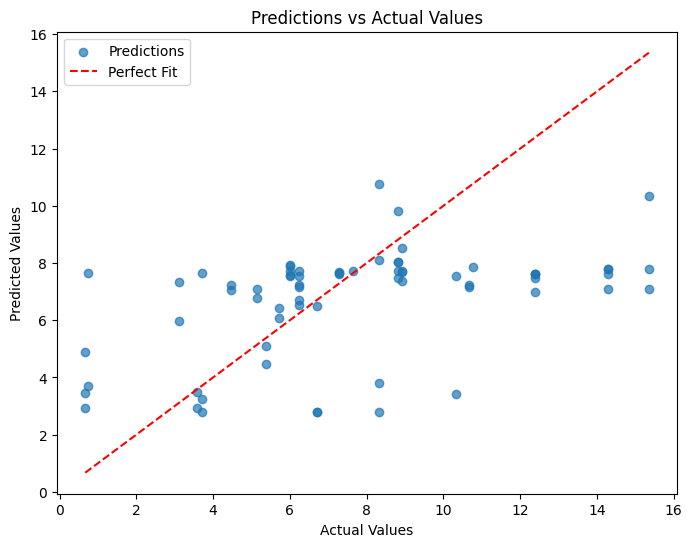

In [ ]:

# Predictions on validation set
y_pred = best_model.predict(X_val)

# Calculate regression metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

In [ ]:
# Function to calculate volume using Van Wagner's formula
def calculate_van_wagner_volumes(data, transect_length=60):
    volumes = []
    for row in data['obserwacje']:
        diameters = [tree[1] for tree in row]  # Convert diameters to meters
        volume = (np.pi**2 / 8) * sum(d**2 for d in diameters) / transect_length
        volumes.append(volume)
    return volumes

# Calculate volumes for each row
data['volume'] = calculate_van_wagner_volumes(data)

print(data)

                                            obserwacje  objetosc      volume
0    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653   75.194049
1    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653   53.851029
2    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...  7.270653   41.149054
3     [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]  7.270653   31.459364
4    [[sw , 11.0], [br, 21.0], [br, 29.0], [os, 18....  7.270653   43.734685
..                                                 ...       ...         ...
334  [[sw, 16.0], [db, 11.0], [db, 24.0], [sw , 18....  6.002460  127.626322
335                                       [[sw, 16.0]]  6.002460    5.263789
336  [[sw , 15.0], [db, 65.0], [db, 50.0], [sw , 34...  6.002460  174.409275
337  [[sw , 31.0], [br, 20.0], [sw , 11.0], [db, 41...  6.002460   70.978905
338  [[db, 11.0], [db, 24.0], [sw , 18.0], [db, 63....  6.002460  122.362533

[339 rows x 3 columns]


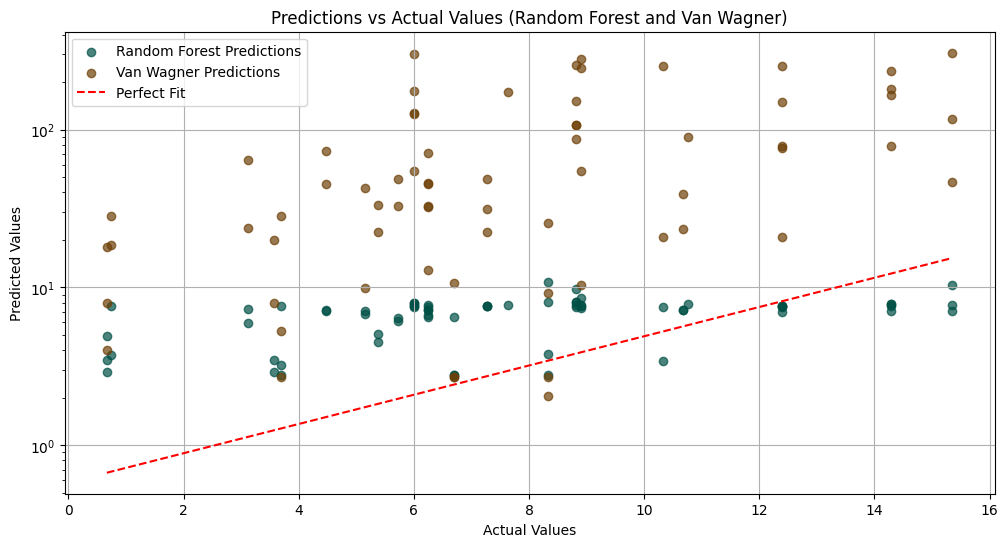

In [ ]:
# Add Van Wagner predictions to the plot
van_wagner_pred = data.loc[y_val.index, 'volume']  # Get Van Wagner volumes for the validation set

plt.figure(figsize=(12, 6))

# Get colors from the 'BrBG' colormap
cmap = plt.get_cmap('BrBG')
colors = [cmap(0.95), cmap(0.05)] # Select colors from the extremes of the colormap for better contrast

# Use selected colors for each model's predictions
plt.scatter(y_val, y_pred, alpha=0.7, label='Random Forest Predictions', color=colors[0])
plt.scatter(y_val, van_wagner_pred, alpha=0.7, label='Van Wagner Predictions', color=colors[1])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Fit') # Perfect fit line remains red

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values (Random Forest and Van Wagner)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True) # Add grid to the plot
plt.show()

In [ ]:
# Load the CSV file
file_path = 'data/PELN - transekt liniowy środa.csv'
data = pd.read_csv(file_path)

# Clean the 'Średnica' column: replace '-' with NaN and convert to numeric
data['Średnica'] = data['Średnica'].astype(str).str.replace(',', '.').replace('-', np.nan)
data['Średnica'] = pd.to_numeric(data['Średnica'], errors='coerce')

# Drop rows where 'Średnica' is NaN after coercion
data.dropna(subset=['Średnica'], inplace=True)


# Create the desired DataFrame
def create_observations(data):
    grouped = data.groupby('Numer grupy (od lewej)')
    observations = grouped.apply(
        lambda group: group[['Gatunek', 'Średnica']].values.tolist()
    )
    return pd.DataFrame({'Tranzekt': observations.index, 'obserwacje': observations.values})

# Generate the DataFrame
new_data_df = create_observations(data)

print(new_data_df)

   Tranzekt                                         obserwacje
0         1  [[sw, 13.5], [Sw, 43.5], [gb , 10.0], [js, 17....
1         2  [[gb, 10.5], [sw, 30.5], [sw, 13.5], [gb, 17.5...
2         3  [[js, 21.0], [gb, 65.0], [sw, 18.0], [sw, 21.0...
3         4  [[js, 14.0], [gb, 20.5], [sw, 23.0], [sw, 17.0...
4         5  [[js, 21.0], [js, 16.5], [js, 10.5], [js, 13.0...


/var/folders/d8/w39s4pfn1r7bx7sn0b5r72g80000gn/T/ipykernel_89966/2623758668.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  observations = grouped.apply(


In [ ]:
# Function to split transect data into exactly 8 segments
def split_transect_to_8_segments(transect_data):
    """
    Split a transect into exactly 8 segments
    Each segment represents 60m of the 500m transect (8 × 60m = 480m, leaving 20m unused)
    """
    segments = []
    total_trees = len(transect_data)
    
    if total_trees == 0:
        # Return 8 empty segments if no trees
        return [[] for _ in range(8)]
    
    # Distribute trees evenly across 8 segments
    trees_per_segment = total_trees // 8
    remaining_trees = total_trees % 8
    
    start_idx = 0
    for i in range(8):
        # Add one extra tree to the first 'remaining_trees' segments
        segment_size = trees_per_segment + (1 if i < remaining_trees else 0)
        
        if segment_size > 0:
            segment = transect_data[start_idx:start_idx + segment_size]
            segments.append(segment)
            start_idx += segment_size
        else:
            segments.append([])  # Empty segment
    
    return segments

# Process each transect by splitting into exactly 8 segments
transect_predictions = []

print("Processing transects by splitting into exactly 8 segments:")
print("=" * 60)

for idx, row in new_data_df.iterrows():
    transect_id = row['Tranzekt']
    transect_observations = row['obserwacje']
    
    print(f"\nTransect {transect_id}:")
    print(f"Total trees: {len(transect_observations)}")
    
    # Split transect into exactly 8 segments
    segments = split_transect_to_8_segments(transect_observations)
    
    print(f"Number of segments: {len(segments)} (fixed)")
    
    segment_predictions = []
    
    # Process each of the 8 segments
    for seg_idx, segment in enumerate(segments):
        if len(segment) > 0:
            # Create temporary dataframe for this segment
            segment_df = pd.DataFrame({'obserwacje': [segment]})
            
            # Process segment data
            processed_segment, _ = preprocess_data(segment_df, encoder=encoder)
            
            # Make prediction for this segment
            segment_pred = best_model.predict(processed_segment)[0]
            segment_predictions.append(segment_pred)
            
            print(f"  Segment {seg_idx + 1}: {len(segment)} trees, prediction: {segment_pred:.4f} m³")
        else:
            segment_predictions.append(0.0)
            print(f"  Segment {seg_idx + 1}: 0 trees, prediction: 0.0000 m³")
    
    # Calculate total prediction for the transect
    total_prediction = sum(segment_predictions)
    
    # Scale to per hectare
    # 8 segments × 0.09 ha per segment = 0.72 ha total area surveyed
    # Scale factor: 0.72 ha -> 1 ha
    surveyed_area_ha = 8 * 0.09  # 0.72 ha
    scale_factor = 1.0 / surveyed_area_ha  # Convert from 0.72 ha to 1 ha
    
    total_per_hectare = total_prediction * scale_factor
    
    transect_predictions.append({
        'transect_id': transect_id,
        'total_trees': len(transect_observations),
        'num_segments': 8,  # Always 8
        'segment_predictions': segment_predictions,
        'total_prediction': total_prediction,
        'surveyed_area_ha': surveyed_area_ha,
        'total_per_hectare': total_per_hectare
    })
    
    print(f"  Total prediction for 0.72 ha: {total_prediction:.4f} m³")
    print(f"  Scaled to per hectare: {total_per_hectare:.4f} m³/ha")

# Extract predictions for further analysis
new_data_predictions = [pred['total_per_hectare'] for pred in transect_predictions]

print("\n" + "=" * 60)
print("SUMMARY - Random Forest Predictions (scaled to per hectare):")
print("=" * 60)
for pred in transect_predictions:
    print(f"Transect {pred['transect_id']}: {pred['total_per_hectare']:.4f} m³/ha")
    print(f"  (Based on {pred['surveyed_area_ha']:.2f} ha surveyed area with {pred['total_trees']} trees)")

print(f"\nOverall statistics:")
print(f"Mean: {np.mean(new_data_predictions):.4f} m³/ha")
print(f"Std: {np.std(new_data_predictions):.4f} m³/ha")
print(f"Min: {np.min(new_data_predictions):.4f} m³/ha")
print(f"Max: {np.max(new_data_predictions):.4f} m³/ha")

Processing transects by splitting into exactly 8 segments:

Transect 1:
Total trees: 45
Number of segments: 8 (fixed)
  Segment 1: 6 trees, prediction: 7.6441 m³
  Segment 2: 6 trees, prediction: 4.6749 m³
  Segment 3: 6 trees, prediction: 7.6038 m³
  Segment 4: 6 trees, prediction: 7.5387 m³
  Segment 5: 6 trees, prediction: 7.7784 m³
  Segment 6: 5 trees, prediction: 4.3720 m³
  Segment 7: 5 trees, prediction: 7.5688 m³
  Segment 8: 5 trees, prediction: 7.9170 m³
  Total prediction for 0.72 ha: 55.0978 m³
  Scaled to per hectare: 76.5247 m³/ha

Transect 2:
Total trees: 38
Number of segments: 8 (fixed)
  Segment 1: 5 trees, prediction: 7.0918 m³
  Segment 2: 5 trees, prediction: 8.0712 m³
  Segment 3: 5 trees, prediction: 7.6739 m³
  Segment 4: 5 trees, prediction: 3.7376 m³
  Segment 5: 5 trees, prediction: 7.9043 m³
  Segment 6: 5 trees, prediction: 7.5522 m³
  Segment 7: 4 trees, prediction: 7.6038 m³
  Segment 8: 4 trees, prediction: 8.0712 m³
  Total prediction for 0.72 ha: 57.70

In [ ]:
# Calculate Van Wagner volumes for the actual surveyed area
# Using 500m transect length but providing volume for 0.72 ha area

def calculate_van_wagner_volumes_actual_area(data, transect_length=500):
    """
    Calculate Van Wagner volumes for the actual surveyed area (0.72 ha)
    """
    volumes_for_area = []
    
    print("Van Wagner Formula Calculations:")
    print("=" * 50)
    print("(Volume calculated for actual surveyed area of 0.72 ha)")
    
    for idx, row in data.iterrows():
        transect_id = row['Tranzekt']
        observations = row['obserwacje']
        
        if len(observations) > 0:
            diameters = [tree[1] for tree in observations]  # Diameters in cm
            
            # Van Wagner formula: V = (π²/8) * Σ(d²) / L
            # where d is diameter in cm, L is transect length in m
            volume_total = (np.pi**2 / 8) * sum(d**2 for d in diameters) / transect_length
            
            # This gives volume per unit area intersected by the transect
            surveyed_area_ha = 0.72
            volume_for_surveyed_area = volume_total 
            
            print(f"Transect {transect_id}: {len(observations)} trees, Σ(d²)={sum(d**2 for d in diameters):.1f}")
            print(f"  Volume for {surveyed_area_ha} ha: {volume_for_surveyed_area:.4f} m³")
        else:
            volume_for_surveyed_area = 0.0
            print(f"Transect {transect_id}: 0 trees")
            
        volumes_for_area.append(volume_for_surveyed_area)
    
    return volumes_for_area

# Calculate Van Wagner predictions for actual surveyed area
pred_wagner_new_area = calculate_van_wagner_volumes_actual_area(new_data_df, transect_length=500)

# Also calculate per hectare for comparison
pred_wagner_new_per_ha = [vol for vol in pred_wagner_new_area]

print(f"\nVan Wagner Summary:")
print(f"For 0.72 ha surveyed area:")
print(f"  Mean: {np.mean(pred_wagner_new_area):.4f} m³")
print(f"  Std: {np.std(pred_wagner_new_area):.4f} m³")
print(f"  Min: {np.min(pred_wagner_new_area):.4f} m³")
print(f"  Max: {np.max(pred_wagner_new_area):.4f} m³")

print(f"Scaled to per hectare (for comparison):")
print(f"  Mean: {np.mean(pred_wagner_new_per_ha):.4f} m³/ha")
print(f"  Std: {np.std(pred_wagner_new_per_ha):.4f} m³/ha")
print(f"  Min: {np.min(pred_wagner_new_per_ha):.4f} m³/ha")
print(f"  Max: {np.max(pred_wagner_new_per_ha):.4f} m³/ha")

Van Wagner Formula Calculations:
(Volume calculated for actual surveyed area of 0.72 ha)
Transect 1: 45 trees, Σ(d²)=28150.0
  Volume for 0.72 ha: 69.4573 m³
Transect 2: 38 trees, Σ(d²)=26709.8
  Volume for 0.72 ha: 65.9037 m³
Transect 3: 27 trees, Σ(d²)=27747.0
  Volume for 0.72 ha: 68.4630 m³
Transect 4: 34 trees, Σ(d²)=17746.2
  Volume for 0.72 ha: 43.7871 m³
Transect 5: 49 trees, Σ(d²)=28577.5
  Volume for 0.72 ha: 70.5122 m³

Van Wagner Summary:
For 0.72 ha surveyed area:
  Mean: 63.6247 m³
  Std: 10.0358 m³
  Min: 43.7871 m³
  Max: 70.5122 m³
Scaled to per hectare (for comparison):
  Mean: 63.6247 m³/ha
  Std: 10.0358 m³/ha
  Min: 43.7871 m³/ha
  Max: 70.5122 m³/ha


COMPREHENSIVE RESULTS FOR NEW TRANSECTS
Dead Wood Volume Estimates (8 segments × 0.09 ha = 0.72 ha surveyed area)
 Transect  RF_Volume_0.72ha  RF_Volume_per_ha  VW_Volume_0.72ha  VW_Volume_per_ha  Number_of_Trees  Average_Diameter_cm  Surveyed_Area_ha
        1           55.0978           76.5247           69.4573           69.4573               45              22.8889            0.7200
        2           57.7060           80.1472           65.9037           65.9037               38              24.7763            0.7200
        3           60.6146           84.1870           68.4630           68.4630               27              29.4444            0.7200
        4           56.7860           78.8695           43.7871           43.7871               34              21.2500            0.7200
        5           48.0989           66.8040           70.5122           70.5122               49              21.6122            0.7200


METHOD COMPARISON SUMMARY
Random Forest Method (scaled t

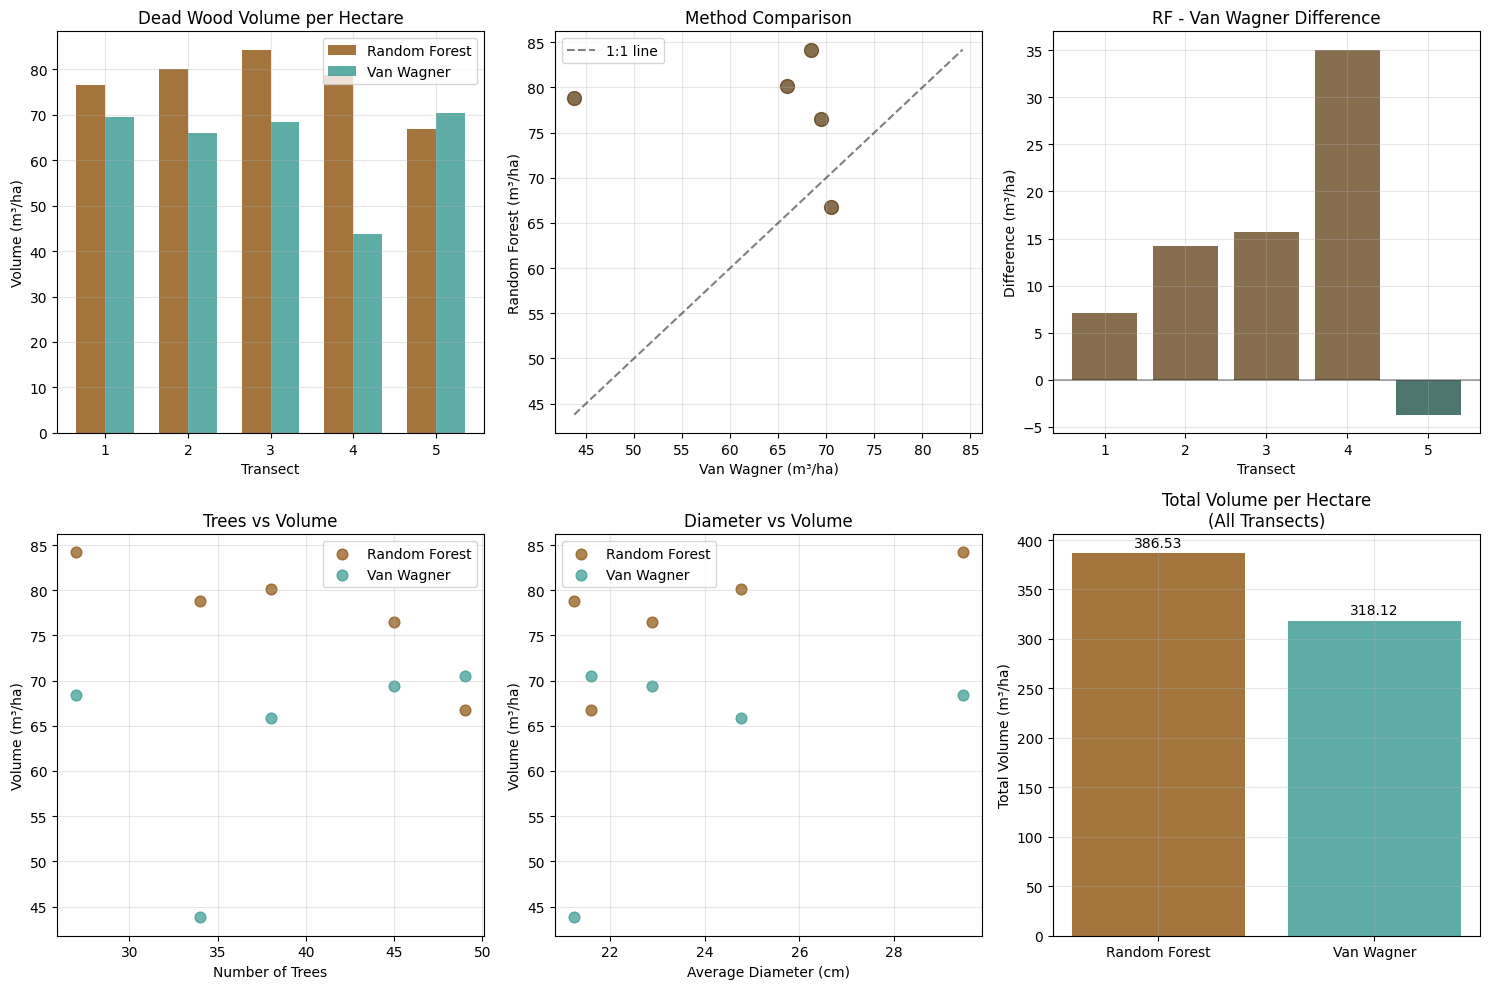


FINAL SUMMARY:
Methodology:
- Random Forest: 8 segments × 0.09 ha = 0.72 ha surveyed, scaled to per hectare
- Van Wagner: Volume calculated for 0.72 ha actual area, also shown per hectare
- Total trees across all transects: 193
- Mean trees per transect: 38.6
- Mean diameter across all trees: 23.6 cm


In [ ]:
# Create a comprehensive comparison table with both actual area and per-hectare values
results_df = pd.DataFrame({
    'Transect': new_data_df['Tranzekt'],
    'RF_Volume_0.72ha': [pred['total_prediction'] for pred in transect_predictions],
    'RF_Volume_per_ha': new_data_predictions,
    'VW_Volume_0.72ha': pred_wagner_new_area,
    'VW_Volume_per_ha': pred_wagner_new_per_ha,
    'Number_of_Trees': [len(obs) for obs in new_data_df['obserwacje']],
    'Average_Diameter_cm': [np.mean([tree[1] for tree in obs]) if obs else 0 for obs in new_data_df['obserwacje']],
    'Surveyed_Area_ha': [pred['surveyed_area_ha'] for pred in transect_predictions]
})

print("COMPREHENSIVE RESULTS FOR NEW TRANSECTS")
print("=" * 80)
print("Dead Wood Volume Estimates (8 segments × 0.09 ha = 0.72 ha surveyed area)")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.4f'))

print("\n\nMETHOD COMPARISON SUMMARY")
print("=" * 50)
print(f"Random Forest Method (scaled to per hectare):")
print(f"  - Mean volume per hectare: {results_df['RF_Volume_per_ha'].mean():.4f} m³/ha")
print(f"  - Standard deviation: {results_df['RF_Volume_per_ha'].std():.4f} m³/ha")
print(f"  - Range: {results_df['RF_Volume_per_ha'].min():.4f} - {results_df['RF_Volume_per_ha'].max():.4f} m³/ha")

print(f"\nVan Wagner Method (scaled to per hectare for comparison):")
print(f"  - Mean volume per hectare: {results_df['VW_Volume_per_ha'].mean():.4f} m³/ha")
print(f"  - Standard deviation: {results_df['VW_Volume_per_ha'].std():.4f} m³/ha")
print(f"  - Range: {results_df['VW_Volume_per_ha'].min():.4f} - {results_df['VW_Volume_per_ha'].max():.4f} m³/ha")

print(f"\nActual Surveyed Area Results (0.72 ha):")
print(f"Random Forest - Total for 0.72 ha: {results_df['RF_Volume_0.72ha'].sum():.4f} m³")
print(f"Van Wagner - Total for 0.72 ha: {results_df['VW_Volume_0.72ha'].sum():.4f} m³")

# Calculate correlation between methods (using per hectare values)
if results_df['VW_Volume_per_ha'].std() > 0 and results_df['RF_Volume_per_ha'].std() > 0:
    correlation = np.corrcoef(results_df['RF_Volume_per_ha'], results_df['VW_Volume_per_ha'])[0, 1]
    print(f"\nCorrelation between methods (per ha): {correlation:.4f}")
else:
    print(f"\nCorrelation: Cannot calculate (insufficient variation)")

# Calculate difference statistics (using per hectare values)
results_df['Difference_per_ha'] = results_df['RF_Volume_per_ha'] - results_df['VW_Volume_per_ha']
results_df['Percent_Difference'] = (results_df['Difference_per_ha'] / results_df['VW_Volume_per_ha'] * 100).fillna(0)

print(f"\nDifference Analysis (RF - Van Wagner, per hectare):")
print(f"  - Mean difference: {results_df['Difference_per_ha'].mean():.4f} m³/ha")
print(f"  - Mean percent difference: {results_df['Percent_Difference'].mean():.1f}%")

# Detailed breakdown by transect
print(f"\nDETAILED BREAKDOWN BY TRANSECT:")
print("=" * 70)
for idx, row in results_df.iterrows():
    print(f"Transect {row['Transect']}:")
    print(f"  Trees: {row['Number_of_Trees']}, Avg diameter: {row['Average_Diameter_cm']:.1f} cm")
    print(f"  Surveyed area: {row['Surveyed_Area_ha']:.2f} ha (8 segments)")
    print(f"  Random Forest: {row['RF_Volume_0.72ha']:.4f} m³ (0.72 ha) → {row['RF_Volume_per_ha']:.4f} m³/ha")
    print(f"  Van Wagner: {row['VW_Volume_0.72ha']:.4f} m³ (0.72 ha) → {row['VW_Volume_per_ha']:.4f} m³/ha")
    print(f"  Difference: {row['Difference_per_ha']:.4f} m³/ha ({row['Percent_Difference']:.1f}%)")
    print()

# Define BrBG color palette
BRBG_COLORS = {
    'dark_brown': '#543005',
    'medium_brown': '#8c510a', 
    'light_brown': '#bf812d',
    'dark_green': '#003c30',
    'medium_green': '#35978f',
    'light_gray': '#f5f5f5'
}

# Enhanced visualization with BrBG color palette
plt.figure(figsize=(15, 10))

# Plot 1: Bar comparison by transect (per hectare)
plt.subplot(2, 3, 1)
x = np.arange(len(results_df))
width = 0.35
plt.bar(x - width/2, results_df['RF_Volume_per_ha'], width, label='Random Forest', 
        alpha=0.8, color=BRBG_COLORS['medium_brown'])
plt.bar(x + width/2, results_df['VW_Volume_per_ha'], width, label='Van Wagner', 
        alpha=0.8, color=BRBG_COLORS['medium_green'])
plt.xlabel('Transect')
plt.ylabel('Volume (m³/ha)')
plt.title('Dead Wood Volume per Hectare')
plt.xticks(x, results_df['Transect'])
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot comparison (per hectare)
plt.subplot(2, 3, 2)
plt.scatter(results_df['VW_Volume_per_ha'], results_df['RF_Volume_per_ha'], 
           s=100, alpha=0.7, color=BRBG_COLORS['dark_brown'])
min_val = min(results_df['VW_Volume_per_ha'].min(), results_df['RF_Volume_per_ha'].min())
max_val = max(results_df['VW_Volume_per_ha'].max(), results_df['RF_Volume_per_ha'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 line')
plt.xlabel('Van Wagner (m³/ha)')
plt.ylabel('Random Forest (m³/ha)')
plt.title('Method Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Difference plot (per hectare)
plt.subplot(2, 3, 3)
colors = [BRBG_COLORS['dark_brown'] if x > 0 else BRBG_COLORS['dark_green'] for x in results_df['Difference_per_ha']]
plt.bar(results_df['Transect'], results_df['Difference_per_ha'], alpha=0.7, color=colors)
plt.xlabel('Transect')
plt.ylabel('Difference (m³/ha)')
plt.title('RF - Van Wagner Difference')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Plot 4: Number of trees vs volume (per hectare)
plt.subplot(2, 3, 4)
plt.scatter(results_df['Number_of_Trees'], results_df['RF_Volume_per_ha'], 
           label='Random Forest', alpha=0.7, color=BRBG_COLORS['medium_brown'], s=60)
plt.scatter(results_df['Number_of_Trees'], results_df['VW_Volume_per_ha'], 
           label='Van Wagner', alpha=0.7, color=BRBG_COLORS['medium_green'], s=60)
plt.xlabel('Number of Trees')
plt.ylabel('Volume (m³/ha)')
plt.title('Trees vs Volume')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Average diameter vs volume (per hectare)
plt.subplot(2, 3, 5)
plt.scatter(results_df['Average_Diameter_cm'], results_df['RF_Volume_per_ha'], 
           label='Random Forest', alpha=0.7, color=BRBG_COLORS['medium_brown'], s=60)
plt.scatter(results_df['Average_Diameter_cm'], results_df['VW_Volume_per_ha'], 
           label='Van Wagner', alpha=0.7, color=BRBG_COLORS['medium_green'], s=60)
plt.xlabel('Average Diameter (cm)')
plt.ylabel('Volume (m³/ha)')
plt.title('Diameter vs Volume')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Method totals (per hectare)
plt.subplot(2, 3, 6)
methods = ['Random Forest', 'Van Wagner']
totals_per_ha = [results_df['RF_Volume_per_ha'].sum(), results_df['VW_Volume_per_ha'].sum()]
colors = [BRBG_COLORS['medium_brown'], BRBG_COLORS['medium_green']]
bars = plt.bar(methods, totals_per_ha, alpha=0.8, color=colors)
plt.ylabel('Total Volume (m³/ha)')
plt.title('Total Volume per Hectare\n(All Transects)')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, total in zip(bars, totals_per_ha):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(totals_per_ha)*0.01, 
             f'{total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nFINAL SUMMARY:")
print("=" * 50)
print("Methodology:")
print("- Random Forest: 8 segments × 0.09 ha = 0.72 ha surveyed, scaled to per hectare")
print("- Van Wagner: Volume calculated for 0.72 ha actual area, also shown per hectare")
print(f"- Total trees across all transects: {results_df['Number_of_Trees'].sum()}")
print(f"- Mean trees per transect: {results_df['Number_of_Trees'].mean():.1f}")
print(f"- Mean diameter across all trees: {np.mean([d for obs in new_data_df['obserwacje'] for tree in obs for d in [tree[1]] if obs]):.1f} cm")

In [ ]:
# First, let's check the structure of our dataframes
print("New data columns:", list(new_data_df.columns))
print("New data shape:", new_data_df.shape)
print("\nFirst few rows of new_data_df:")
print(new_data_df.head())

# Fix 1: Print dominant species for each transect using the correct data structure
print("\n\nDOMINANT SPECIES BY TRANSECT:")
print("=" * 50)

# The data structure shows that each transect has observations in a nested format
# Let's parse the observations for each transect
for _, row in new_data_df.iterrows():
    transect_id = row['Tranzekt']
    observations = row['obserwacje']
    
    # Count species occurrences
    species_counts = {}
    total_trees = len(observations)
    
    for obs in observations:
        species = obs[0]  # First element is species
        diameter = obs[1]  # Second element is diameter
        
        species_counts[species] = species_counts.get(species, 0) + 1
    
    if species_counts:
        dominant_species = max(species_counts, key=species_counts.get)
        dominant_count = species_counts[dominant_species]
        percentage = (dominant_count / total_trees) * 100
        
        print(f"Transect {transect_id}: {dominant_species} ({dominant_count}/{total_trees} trees, {percentage:.1f}%)")
        
        # Show all species in this transect
        print(f"  All species in transect {transect_id}: {dict(species_counts)}")

print("\n\nSTATISTICAL TEST:")
print("=" * 50)

from scipy import stats

# Get the per-hectare values for statistical test
rf_values = results_df['RF_Volume_per_ha'].values
vw_values = results_df['VW_Volume_per_ha'].values

# Perform paired t-test (since we have matched pairs from same transects)
t_stat, p_value = stats.ttest_rel(rf_values, vw_values)

print(f"Paired t-test results:")
print(f"Random Forest mean: {rf_values.mean():.2f} m³/ha")
print(f"Van Wagner mean: {vw_values.mean():.2f} m³/ha")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Check if RF mean is significantly greater than VW mean
alpha = 0.05
if p_value < alpha and t_stat > 0:
    test_result = f"RF significantly greater than VW (p={p_value:.4f})"
    is_significant = True
elif p_value < alpha and t_stat < 0:
    test_result = f"VW significantly greater than RF (p={p_value:.4f})"
    is_significant = True
else:
    test_result = f"No significant difference (p={p_value:.4f})"
    is_significant = False

print(f"Conclusion: {test_result}")

# Store result for use in plots
statistical_test_result = test_result

New data columns: ['Tranzekt', 'obserwacje']
New data shape: (5, 2)

First few rows of new_data_df:
   Tranzekt                                         obserwacje
0         1  [[sw, 13.5], [Sw, 43.5], [gb , 10.0], [js, 17....
1         2  [[gb, 10.5], [sw, 30.5], [sw, 13.5], [gb, 17.5...
2         3  [[js, 21.0], [gb, 65.0], [sw, 18.0], [sw, 21.0...
3         4  [[js, 14.0], [gb, 20.5], [sw, 23.0], [sw, 17.0...
4         5  [[js, 21.0], [js, 16.5], [js, 10.5], [js, 13.0...


DOMINANT SPECIES BY TRANSECT:
Transect 1: sw (26/45 trees, 57.8%)
  All species in transect 1: {'sw': 26, 'Sw': 1, 'gb ': 1, 'js': 3, 'gb': 7, 'db ': 1, 'db': 5, 'lp': 1}
Transect 2: sw (13/38 trees, 34.2%)
  All species in transect 2: {'gb': 7, 'sw': 13, 'js': 7, 'lp': 4, 'db': 4, 'os': 1, 'br': 2}
Transect 3: gb (11/27 trees, 40.7%)
  All species in transect 3: {'js': 3, 'gb': 11, 'sw': 10, 'lp': 3}
Transect 4: sw (16/34 trees, 47.1%)
  All species in transect 4: {'js': 2, 'gb': 8, 'sw': 16, 'lp': 6, 'os': 2}
Tra

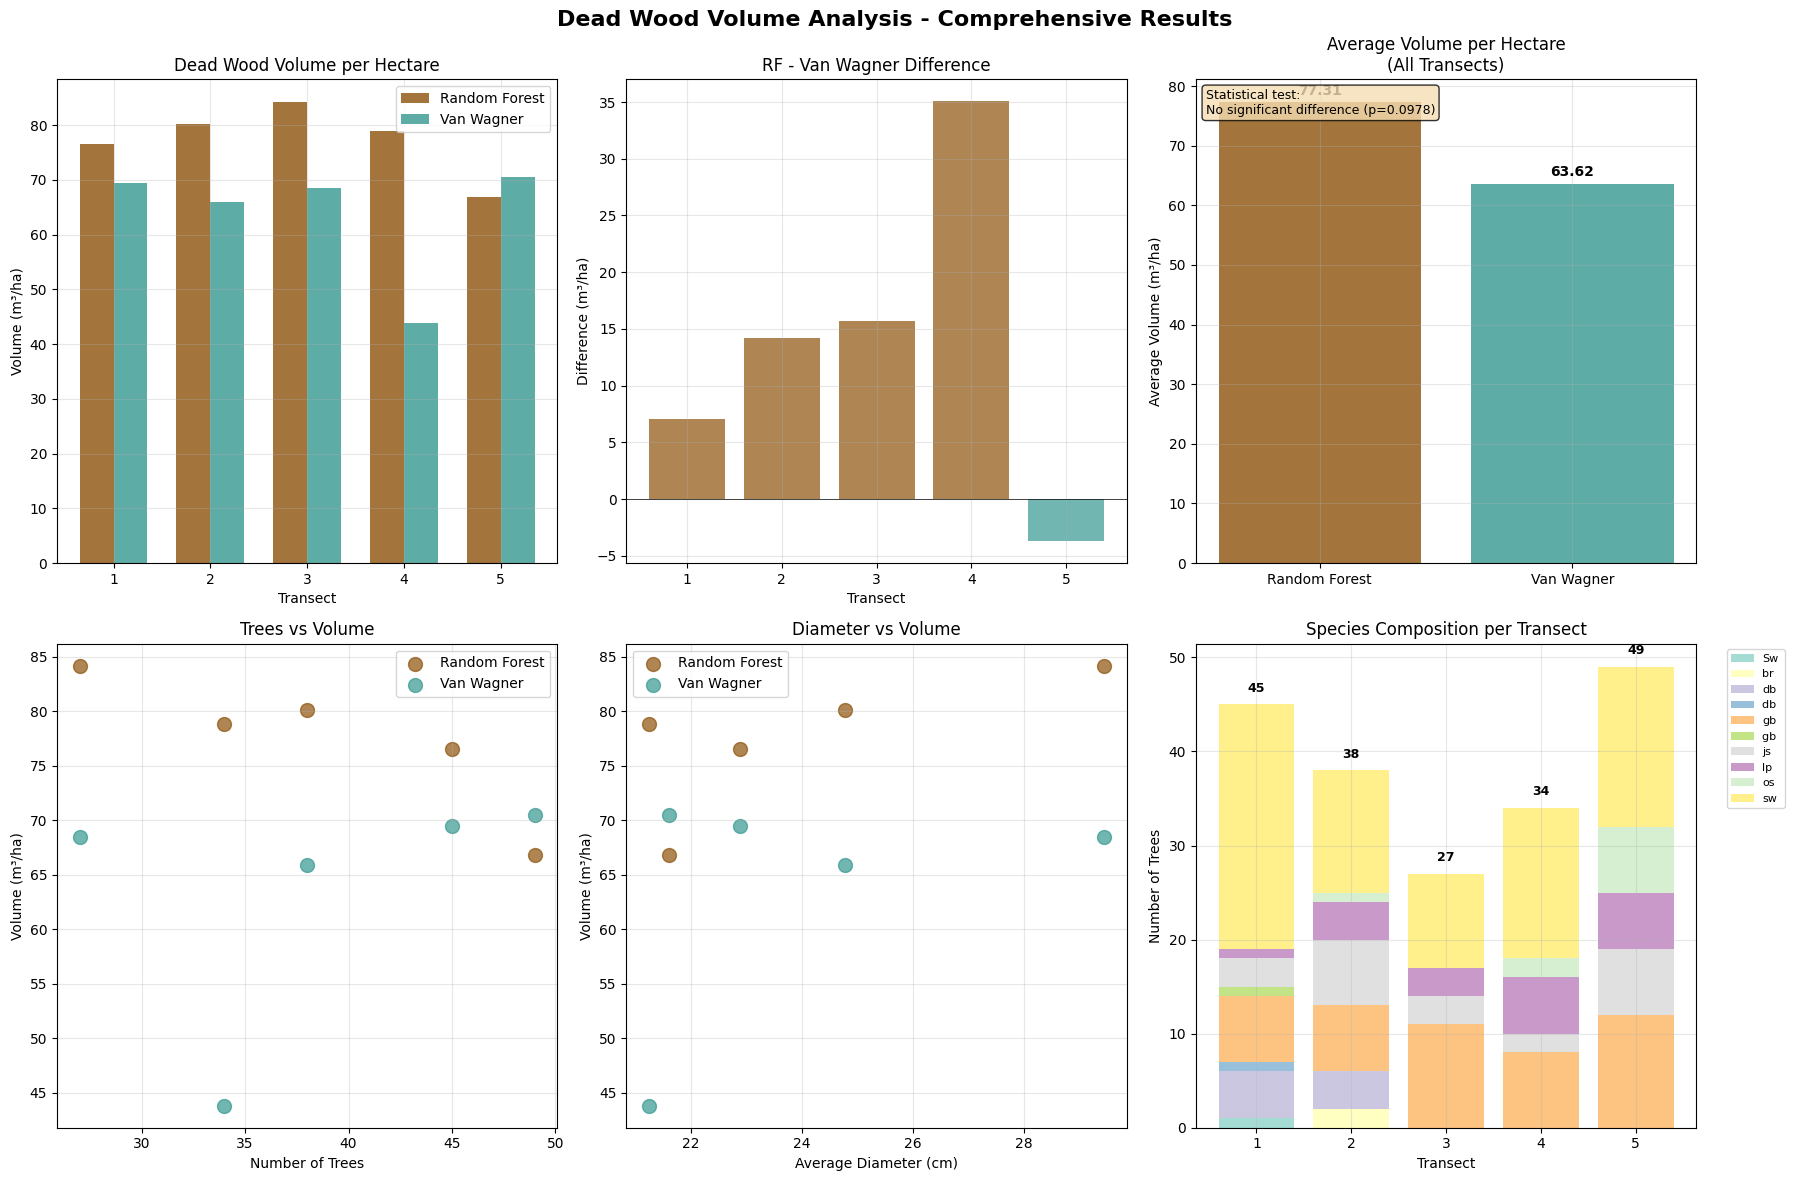



CORRECTED AVERAGES:
Random Forest average: 77.31 m³/ha
Van Wagner average: 63.62 m³/ha
Statistical test result: No significant difference (p=0.0978)


TREES PER TRANSECT:
Transect 1: 45 trees
Transect 2: 38 trees
Transect 3: 27 trees
Transect 4: 34 trees
Transect 5: 49 trees


AVERAGE DIAMETER PER TRANSECT:
Transect 1: 22.9 cm
Transect 2: 24.8 cm
Transect 3: 29.4 cm
Transect 4: 21.2 cm
Transect 5: 21.6 cm


SPECIES COMPOSITION PER TRANSECT:
Transect 1 (45 trees total):
  sw: 26 trees (57.8%)
  gb: 7 trees (15.6%)
  db: 5 trees (11.1%)
  js: 3 trees (6.7%)
  Sw: 1 trees (2.2%)
  gb : 1 trees (2.2%)
  db : 1 trees (2.2%)
  lp: 1 trees (2.2%)

Transect 2 (38 trees total):
  sw: 13 trees (34.2%)
  gb: 7 trees (18.4%)
  js: 7 trees (18.4%)
  lp: 4 trees (10.5%)
  db: 4 trees (10.5%)
  br: 2 trees (5.3%)
  os: 1 trees (2.6%)

Transect 3 (27 trees total):
  gb: 11 trees (40.7%)
  sw: 10 trees (37.0%)
  js: 3 trees (11.1%)
  lp: 3 trees (11.1%)

Transect 4 (34 trees total):
  sw: 16 trees (4

In [ ]:
# Fix 3: Create updated visualizations with corrections
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define custom BrBG color palette
BRBG_COLORS = {
    'brown': '#8c510a',
    'light_brown': '#bf812d', 
    'beige': '#dfc27d',
    'light_teal': '#80cdc1',
    'teal': '#35978f',
    'dark_teal': '#01665e'
}

colors = [BRBG_COLORS['brown'], BRBG_COLORS['teal']]
cmap = LinearSegmentedColormap.from_list("custom_BrBG", colors, N=256)

# Create the corrected visualization - REMOVE Method Comparison plot as requested
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dead Wood Volume Analysis - Comprehensive Results', fontsize=16, fontweight='bold')

# Subplot 1: Dead Wood Volume per Hectare by Transect
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35

ax1.bar(x - width/2, results_df['RF_Volume_per_ha'], width, label='Random Forest', 
        color=colors[0], alpha=0.8)
ax1.bar(x + width/2, results_df['VW_Volume_per_ha'], width, label='Van Wagner', 
        color=colors[1], alpha=0.8)

ax1.set_xlabel('Transect')
ax1.set_ylabel('Volume (m³/ha)')
ax1.set_title('Dead Wood Volume per Hectare')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Transect'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: RF - Van Wagner Difference
ax2 = axes[0, 1]
colors_diff = [colors[0] if diff >= 0 else colors[1] for diff in results_df['Difference_per_ha']]
ax2.bar(results_df['Transect'], results_df['Difference_per_ha'], alpha=0.7, color=colors_diff)
ax2.set_xlabel('Transect')
ax2.set_ylabel('Difference (m³/ha)')
ax2.set_title('RF - Van Wagner Difference')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3)

# Subplot 3: CORRECTED Average Volume per Hectare (All Transects) - with statistical test
ax3 = axes[0, 2]
methods = ['Random Forest', 'Van Wagner']

# FIX: Use mean instead of sum for averages
averages_per_ha = [results_df['RF_Volume_per_ha'].mean(), results_df['VW_Volume_per_ha'].mean()]

bars = ax3.bar(methods, averages_per_ha, alpha=0.8, color=colors)
ax3.set_ylabel('Average Volume (m³/ha)')
ax3.set_title('Average Volume per Hectare\n(All Transects)')

# Add value labels on bars
for bar, avg in zip(bars, averages_per_ha):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(averages_per_ha)*0.01, 
            f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')

# Add statistical test result to legend/text
ax3.text(0.02, 0.98, f'Statistical test:\n{statistical_test_result}', 
         transform=ax3.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax3.grid(True, alpha=0.3)

# Subplot 4: Trees vs Volume
ax4 = axes[1, 0]
# Calculate number of trees per transect using the correct data structure
trees_per_transect = [len(new_data_df[new_data_df['Tranzekt'] == i]['obserwacje'].iloc[0]) for i in range(1, 6)]

ax4.scatter(trees_per_transect, results_df['RF_Volume_per_ha'], 
           s=100, alpha=0.7, color=colors[0], label='Random Forest')
ax4.scatter(trees_per_transect, results_df['VW_Volume_per_ha'], 
           s=100, alpha=0.7, color=colors[1], label='Van Wagner')
ax4.set_xlabel('Number of Trees')
ax4.set_ylabel('Volume (m³/ha)')
ax4.set_title('Trees vs Volume')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Subplot 5: Diameter vs Volume
ax5 = axes[1, 1]
# Calculate average diameter per transect using the correct data structure
avg_diameter_per_transect = []
for i in range(1, 6):
    transect_data = new_data_df[new_data_df['Tranzekt'] == i]['obserwacje'].iloc[0]
    diameters = [obs[1] for obs in transect_data]  # Second element is diameter
    avg_diameter_per_transect.append(np.mean(diameters))

ax5.scatter(avg_diameter_per_transect, results_df['RF_Volume_per_ha'], 
           s=100, alpha=0.7, color=colors[0], label='Random Forest')
ax5.scatter(avg_diameter_per_transect, results_df['VW_Volume_per_ha'], 
           s=100, alpha=0.7, color=colors[1], label='Van Wagner')
ax5.set_xlabel('Average Diameter (cm)')
ax5.set_ylabel('Volume (m³/ha)')
ax5.set_title('Diameter vs Volume')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Subplot 6: Species composition by transect (stacked bar chart)
ax6 = axes[1, 2]

# Collect species data for all transects
all_species_data = {}
transects = list(range(1, 6))

for i in range(1, 6):
    transect_data = new_data_df[new_data_df['Tranzekt'] == i]['obserwacje'].iloc[0]
    species_counts = {}
    for obs in transect_data:
        species = obs[0]  # First element is species
        species_counts[species] = species_counts.get(species, 0) + 1
    all_species_data[i] = species_counts

# Get all unique species across all transects
all_species = set()
for species_dict in all_species_data.values():
    all_species.update(species_dict.keys())
all_species = sorted(list(all_species))

# Create a colormap for species
species_colors = plt.cm.Set3(np.linspace(0, 1, len(all_species)))

# Prepare data for stacked bar chart
species_data_matrix = []
for species in all_species:
    species_counts_per_transect = []
    for transect in transects:
        count = all_species_data[transect].get(species, 0)
        species_counts_per_transect.append(count)
    species_data_matrix.append(species_counts_per_transect)

# Create stacked bar chart
bottom = np.zeros(len(transects))
bars_list = []

for i, (species, species_counts) in enumerate(zip(all_species, species_data_matrix)):
    bars = ax6.bar(transects, species_counts, bottom=bottom, 
                   label=species, color=species_colors[i], alpha=0.8)
    bars_list.append(bars)
    bottom += np.array(species_counts)

ax6.set_xlabel('Transect')
ax6.set_ylabel('Number of Trees')
ax6.set_title('Species Composition per Transect')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)

# Add total count labels on top of each bar
for i, transect in enumerate(transects):
    total_trees = sum([species_data_matrix[j][i] for j in range(len(all_species))])
    ax6.text(transect, total_trees + 1, f'{total_trees}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n\nCORRECTED AVERAGES:")
print(f"Random Forest average: {averages_per_ha[0]:.2f} m³/ha")
print(f"Van Wagner average: {averages_per_ha[1]:.2f} m³/ha")
print(f"Statistical test result: {statistical_test_result}")

print(f"\n\nTREES PER TRANSECT:")
for i, count in enumerate(trees_per_transect, 1):
    print(f"Transect {i}: {count} trees")

print(f"\n\nAVERAGE DIAMETER PER TRANSECT:")
for i, avg_diam in enumerate(avg_diameter_per_transect, 1):
    print(f"Transect {i}: {avg_diam:.1f} cm")

print(f"\n\nSPECIES COMPOSITION PER TRANSECT:")
for transect in transects:
    species_counts = all_species_data[transect]
    total_trees_transect = sum(species_counts.values())
    print(f"Transect {transect} ({total_trees_transect} trees total):")
    
    # Sort species by count (descending)
    sorted_species = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
    for species, count in sorted_species:
        percentage = (count / total_trees_transect) * 100
        print(f"  {species}: {count} trees ({percentage:.1f}%)")
    print()

In [ ]:
# HYPERGEOMETRIC TEST ANALYSIS FOR AVERAGE VOLUME PER HECTARE
print("\n" + "=" * 80)
print("HYPERGEOMETRIC TEST ANALYSIS")
print("=" * 80)

from scipy.stats import hypergeom
import numpy as np

# Get the volume data
rf_volumes = results_df['RF_Volume_per_ha'].values
vw_volumes = results_df['VW_Volume_per_ha'].values

print(f"Random Forest volumes per hectare: {rf_volumes}")
print(f"Van Wagner volumes per hectare: {vw_volumes}")

# Method 1: Categorical Analysis (High vs Low Volume)
# Define threshold as median of combined volumes
combined_volumes = np.concatenate([rf_volumes, vw_volumes])
threshold = np.median(combined_volumes)

print(f"\nMethod 1: Categorical Analysis (High vs Low Volume)")
print(f"Threshold (median): {threshold:.2f} m³/ha")

# Categorize volumes as high (1) or low (0)
rf_high = (rf_volumes > threshold).astype(int)
vw_high = (vw_volumes > threshold).astype(int)

print(f"Random Forest - High volume counts: {rf_high} (total high: {rf_high.sum()})")
print(f"Van Wagner - High volume counts: {vw_high} (total high: {vw_high.sum()})")

# Hypergeometric test parameters
N = len(rf_volumes) + len(vw_volumes)  # Total population size
K = rf_high.sum() + vw_high.sum()      # Total number of "successes" (high volumes)
n = len(rf_volumes)                    # Sample size (RF observations)
k = rf_high.sum()                      # Observed successes in sample (RF high volumes)

print(f"\nHypergeometric test parameters:")
print(f"N (total population): {N}")
print(f"K (total high volumes): {K}")
print(f"n (RF sample size): {n}")
print(f"k (RF high volumes observed): {k}")

# Calculate hypergeometric probability
# Test if RF has significantly more high volumes than expected
p_value_hyper = 1 - hypergeom.cdf(k-1, N, K, n)  # P(X >= k)

print(f"\nHypergeometric test results:")
print(f"P-value (RF has more high volumes): {p_value_hyper:.4f}")

if p_value_hyper < 0.05:
    hyper_result = f"RF significantly more high volumes (p={p_value_hyper:.4f})"
else:
    hyper_result = f"No significant difference in high volume proportion (p={p_value_hyper:.4f})"

print(f"Conclusion: {hyper_result}")

# Method 2: Rank-based Hypergeometric Test
print(f"\n\nMethod 2: Rank-based Analysis")

# Combine and rank all volumes
all_volumes = list(zip(rf_volumes, ['RF']*len(rf_volumes))) + list(zip(vw_volumes, ['VW']*len(vw_volumes)))
all_volumes.sort(key=lambda x: x[0], reverse=True)  # Sort by volume (descending)

print(f"Ranked volumes (highest to lowest):")
for i, (vol, method) in enumerate(all_volumes):
    print(f"  Rank {i+1}: {vol:.2f} m³/ha ({method})")

# Take top half as "high performers"
top_half_size = len(all_volumes) // 2
top_performers = all_volumes[:top_half_size]
rf_in_top = sum(1 for vol, method in top_performers if method == 'RF')

print(f"\nTop {top_half_size} performers:")
print(f"RF in top half: {rf_in_top}")
print(f"VW in top half: {top_half_size - rf_in_top}")

# Hypergeometric test for top performers
N_rank = len(all_volumes)
K_rank = len(rf_volumes)  # Total RF observations
n_rank = top_half_size    # Top performers
k_rank = rf_in_top        # RF in top performers

p_value_rank = 1 - hypergeom.cdf(k_rank-1, N_rank, K_rank, n_rank)

print(f"\nRank-based hypergeometric test:")
print(f"N (total observations): {N_rank}")
print(f"K (total RF observations): {K_rank}")
print(f"n (top performers): {n_rank}")
print(f"k (RF in top performers): {k_rank}")
print(f"P-value: {p_value_rank:.4f}")

if p_value_rank < 0.05:
    rank_result = f"RF significantly overrepresented in top performers (p={p_value_rank:.4f})"
else:
    rank_result = f"No significant overrepresentation of RF in top performers (p={p_value_rank:.4f})"

print(f"Conclusion: {rank_result}")

# Method 3: Volume Difference Analysis
print(f"\n\nMethod 3: Volume Difference Analysis")

# Calculate differences and categorize
volume_diffs = rf_volumes - vw_volumes
positive_diffs = (volume_diffs > 0).astype(int)

print(f"Volume differences (RF - VW): {volume_diffs}")
print(f"Positive differences: {positive_diffs} (total: {positive_diffs.sum()})")

# Test if RF consistently outperforms VW
# Under null hypothesis, RF should outperform VW in 50% of cases
expected_positive = len(volume_diffs) / 2
observed_positive = positive_diffs.sum()

# Use hypergeometric framework: what's the probability of observing this many positives?
N_diff = len(volume_diffs) * 2  # Total possible outcomes (positive/negative for each transect)
K_diff = len(volume_diffs)      # Total possible positive outcomes
n_diff = len(volume_diffs)      # Sample size
k_diff = observed_positive      # Observed positive outcomes

p_value_diff = 1 - hypergeom.cdf(k_diff-1, N_diff, K_diff, n_diff)

print(f"\nDifference-based hypergeometric test:")
print(f"Expected positive differences under null: {expected_positive}")
print(f"Observed positive differences: {observed_positive}")
print(f"P-value: {p_value_diff:.4f}")

if p_value_diff < 0.05:
    diff_result = f"RF significantly outperforms VW (p={p_value_diff:.4f})"
else:
    diff_result = f"No significant consistent outperformance (p={p_value_diff:.4f})"

print(f"Conclusion: {diff_result}")

# Summary
print(f"\n" + "=" * 80)
print("HYPERGEOMETRIC TEST SUMMARY")
print("=" * 80)
print(f"1. Categorical test (high vs low volume): {hyper_result}")
print(f"2. Rank-based test (top performers): {rank_result}")
print(f"3. Difference-based test (RF vs VW): {diff_result}")

# Store results for visualization
hypergeometric_results = {
    'categorical': {'p_value': p_value_hyper, 'result': hyper_result},
    'rank_based': {'p_value': p_value_rank, 'result': rank_result},
    'difference': {'p_value': p_value_diff, 'result': diff_result}
}


HYPERGEOMETRIC TEST ANALYSIS
Random Forest volumes per hectare: [76.52471771 80.14716827 84.1869792  78.86949822 66.8039655 ]
Van Wagner volumes per hectare: [69.45734097 65.90366654 68.46297833 43.78711678 70.51215494]

Method 1: Categorical Analysis (High vs Low Volume)
Threshold (median): 69.98 m³/ha
Random Forest - High volume counts: [1 1 1 1 0] (total high: 4)
Van Wagner - High volume counts: [0 0 0 0 1] (total high: 1)

Hypergeometric test parameters:
N (total population): 10
K (total high volumes): 5
n (RF sample size): 5
k (RF high volumes observed): 4

Hypergeometric test results:
P-value (RF has more high volumes): 0.1032
Conclusion: No significant difference in high volume proportion (p=0.1032)


Method 2: Rank-based Analysis
Ranked volumes (highest to lowest):
  Rank 1: 84.19 m³/ha (RF)
  Rank 2: 80.15 m³/ha (RF)
  Rank 3: 78.87 m³/ha (RF)
  Rank 4: 76.52 m³/ha (RF)
  Rank 5: 70.51 m³/ha (VW)
  Rank 6: 69.46 m³/ha (VW)
  Rank 7: 68.46 m³/ha (VW)
  Rank 8: 66.80 m³/ha (RF)